## Informe final: Proyecto 3. Inferencia Estadística y Modelación Estadística

- David Alejandro Cajiao
- Juan Andrés López
- Joan Mateo Bermúdez

#### 1. Problema: Seleccionar una variable categórica como factor y una variable continua como variable dependiente

Supongan que están interesados en investigar si hay diferencias significativas en la variable dependiente entre al menos tres grupos que ustedes escojan de la base de datos del "Census at School".

**Pasos:**

1. **Análisis de Varianza (ANOVA)**: Primero, realizar un ANOVA para determinar si hay diferencias significativas en la variable dependiente entre los diferentes grupos. Deben proporcionar el código de cómo llegaron a las tablas de resumen y ANOVA (ver ejemplo en clase).
2. **Post-ANOVA**: Si el resultado del ANOVA es significativo, realizar un análisis post-hoc para determinar qué grupos específicos difieren en la variable dependiente. Usar la prueba LSD de Fisher.
3. **Intervalos de Confianza**: Calcular los intervalos de confianza para las diferencias en la variable dependiente entre los grupos. Esto les dará una idea de la incertidumbre asociada a las estimaciones de las diferencias.
4. **Gráficas**: Finalmente, visualizar los resultados utilizando un boxplot de la variable dependiente entre los diferentes grupos para visualizar las diferencias. También crear un gráfico de los intervalos de confianza para visualizar la incertidumbre de las estimaciones.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tabulate import tabulate

In [2]:
df = pd.read_csv('./data/cleandata/datasetcleaned.csv')

In [3]:
df = df[~df["Planned_Education_Level"].isnull()]

In [4]:
df = df[df["Height_cm"] < 220]
df = df [df["Ageyears"] < 24]
df = df [df["Height_cm"] > 100]

                                   sum_sq      df         F    PR(>F)
C(Planned_Education_Level)    1763.137933     5.0  2.710332  0.019224
Residual                    141163.841965  1085.0       NaN       NaN
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------
      Graduate degree           High school    4.555 0.0079   0.7753  8.3346   True
      Graduate degree Less than high school   2.1391 0.9975 -11.2114 15.4896  False
      Graduate degree                 Other   0.9505 0.9861  -3.1578  5.0588  False
      Graduate degree          Some college   1.0513 0.9625  -2.5767  4.6794  False
      Graduate degree  Undergraduate degree   1.7653 0.5507  -1.2487  4.7794  False
          High school Less than high school  -2.4158 0.9961 -16.1817 11.3501  False
          High school             

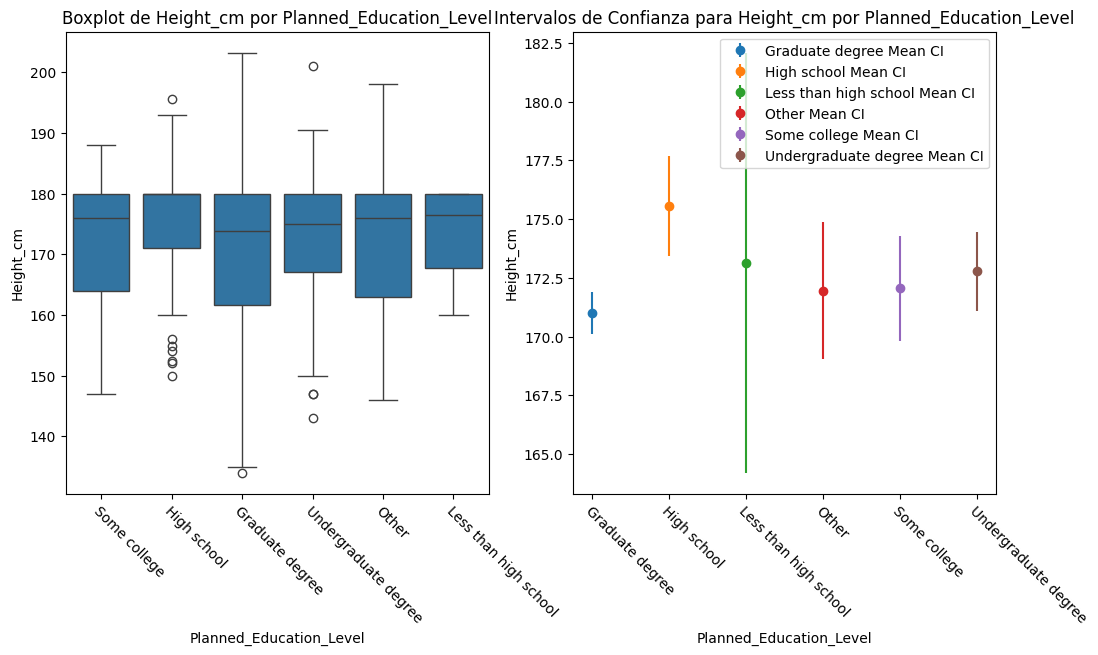

In [5]:
df['Planned_Education_Level'] = df['Planned_Education_Level'].astype('str')
df['Height_cm'] = df['Height_cm'].astype('float')

# Eliminar filas con valores NaN en las columnas relevantes
df = df.dropna(subset=['Planned_Education_Level', 'Height_cm'])

# ANOVA
model = ols('Height_cm ~ C(Planned_Education_Level)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Post-ANOVA (Prueba LSD de Fisher)

tukey = pairwise_tukeyhsd(endog=df['Height_cm'],
                        groups=df['Planned_Education_Level'],
                        alpha=0.05)
print(tukey)

# Intervalos de Confianza
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    m, se = data.mean(), stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return pd.Series([m, m-h, m+h], index=['mean', 'mean - h', 'mean + h'])

confidence_intervals = df.groupby('Planned_Education_Level')['Height_cm'].apply(mean_confidence_interval).unstack()
print(confidence_intervals)

# Gráficas
plt.figure(figsize=(12, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='Planned_Education_Level', y='Height_cm', data=df)
plt.title('Boxplot de Height_cm por Planned_Education_Level')
plt.setp(plt.subplot(1,2,1).get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")

# Gráfico de Intervalos de Confianza
plt.subplot(1, 2, 2)
for level in confidence_intervals.index:
    plt.errorbar(level, confidence_intervals.loc[level, 'mean'], 
                yerr=[[confidence_intervals.loc[level, 'mean'] - confidence_intervals.loc[level, 'mean - h']], 
                    [confidence_intervals.loc[level, 'mean + h'] - confidence_intervals.loc[level, 'mean']]], 
                fmt='o', label=f'{level} Mean CI')
                
plt.setp(plt.subplot(1,2,2).get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
plt.title('Intervalos de Confianza para Height_cm por Planned_Education_Level')
plt.xlabel('Planned_Education_Level')
plt.ylabel('Height_cm')
plt.legend()
plt.show()

-----

#### 2. Problema: Leonardo da Vinci y la relación entre la distancia entre los brazos extendidos y la estatura

Para probar lo dicho por él, usen la base de datos de los 1500 estudiantes del Census at School.

**Pasos:**

1. Traza una gráfica de dispersión para la distancia entre los brazos extendidos y estatura. Usa la misma escala en los ejes horizontal y vertical. Describe la relación entre las dos variables.
2. Si da Vinci estaba en lo correcto y la distancia entre los brazos extendidos de una persona es casi igual a la estatura de esa persona, ¿cuál debe ser la pendiente de la recta de regresión?
3. Calcula la recta de regresión para predecir la estatura con base en la distancia entre los brazos extendidos de una persona. ¿El valor de la pendiente confirma las conclusiones del inciso anterior?
4. Si una persona tiene una distancia de 67 pulgadas entre los brazos extendidos, ¿cuál sería el pronóstico respecto a la estatura de la persona?
5. ¿Los datos dan suficiente evidencia para indicar que hay una relación lineal entre distancia y estatura? Prueba al nivel de significancia de 5 %.
6. Construye un intervalo de confianza de 95 % para la pendiente de la recta de medias.
7. Si Leonardo da Vinci tenía razón y la distancia entre los brazos extendidos de una persona es casi igual a la estatura de esa persona, ¿el intervalo de confianza construido en el inciso anterior confirma esta suposición? Explica.

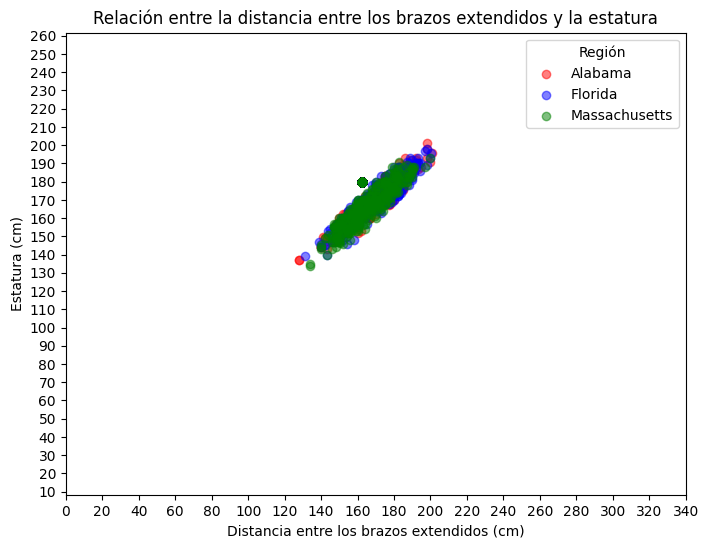


La relación entre la estatura y la distancia entre los brazos extendidos puede ser descrita de la siguiente manera:

╒═════════════════════════════╤═════════╤═══════════════════════╤══════════╤══════════╕
│ Variable                    │   Media │   Desviación estándar │   Mínimo │   Máximo │
╞═════════════════════════════╪═════════╪═══════════════════════╪══════════╪══════════╡
│ Estatura (cm)               │ 171.742 │               11.3235 │      134 │      201 │
├─────────────────────────────┼─────────┼───────────────────────┼──────────┼──────────┤
│ Distancia entre brazos (cm) │ 167.19  │               11.8184 │      128 │      201 │
╘═════════════════════════════╧═════════╧═══════════════════════╧══════════╧══════════╛

Esto proporciona una visión general de las estadísticas descriptivas de ambas variables, incluyendo la media, desviación estándar, mínimo y máximo.



In [6]:
#Traza una gráfica de dispersión para la distancia entre los brazos extendidos y estatura. 
#Usa la misma escala en los ejes horizontal y vertical. 
# Describe la relación entre las dos variables.

df = pd.read_csv("./data/cleandata/datasetcleaned.csv")


# Eliminar filas con valores fuera del rango deseado
df = df[(df['Height_cm'] >= 53) & (df['Height_cm'] <= 201)]
df = df[(df['Armspan_cm'] >= 53) & (df['Armspan_cm'] <= 201)]
# Extraer las columnas relevantes del DataFrame
height = df['Height_cm']
armspan = df['Armspan_cm']
region = df['Region']

# Obtener colores únicos para cada región
region_colors = {'AL': 'red', 'FL': 'blue', 'MA': 'green'}

# Mapear las abreviaturas de región a los nombres completos
region_names = {'AL': 'Alabama', 'FL': 'Florida', 'MA': 'Massachusetts'}

# Crear la gráfica de dispersión con colores por región
plt.figure(figsize=(8, 6))
for region, color in region_colors.items():
    region_data = df[df['Region'] == region]
    plt.scatter(region_data['Armspan_cm'], region_data['Height_cm'], color=color, alpha=0.5, label=region_names[region])

# Establecer la misma escala en ambos ejes
plt.axis('equal')

# Etiquetas de los ejes y título
plt.xlabel('Distancia entre los brazos extendidos (cm)')
plt.ylabel('Estatura (cm)')
plt.title('Relación entre la distancia entre los brazos extendidos y la estatura')
plt.yticks(range(0, 280, 10))
plt.xticks(range(0, 350, 20))
# Agregar leyenda
plt.legend(title='Región')
# Mostrar la gráfica
# plt.savefig("../documentacion_errores/fail1.png")
# plt.savefig("../documentacion_errores/finalplot1.png")
plt.show()


# Calcular estadísticas descriptivas
statistics = {
    'Variable': ['Estatura (cm)', 'Distancia entre brazos (cm)'],
    'Media': [height.mean(), armspan.mean()],
    'Desviación estándar': [height.std(), armspan.std()],
    'Mínimo': [height.min(), armspan.min()],
    'Máximo': [height.max(), armspan.max()]
}

# Formatear estadísticas como tabla utilizando tabulate
table = tabulate(statistics, headers='keys', tablefmt='fancy_grid')

# Mensaje que describe la relación entre las dos variables
relationship_description = """
La relación entre la estatura y la distancia entre los brazos extendidos puede ser descrita de la siguiente manera:

{}

Esto proporciona una visión general de las estadísticas descriptivas de ambas variables, incluyendo la media, desviación estándar, mínimo y máximo.
""".format(table)

# Imprimir la descripción de la relación
print(relationship_description)

In [7]:
#Calcula la recta de regresión para predecir la estatura con base en la distancia entre 
# los brazos extendidos de una persona. 
# ¿El valor de la pendiente confirma las conclusiones del inciso anterior?

# Función para calcular la pendiente de la recta de regresión
def calcular_pendiente_recta_regresion(df, dependent_var, independent_var):
    """
    Calcula la pendiente de la recta de regresión lineal simple.

    Args:
        df (pd.DataFrame): DataFrame que contiene los datos.
        dependent_var (str): Nombre de la variable dependiente.
        independent_var (str): Nombre de la variable independiente.

    Returns:
        float: La pendiente de la recta de regresión.
    """
    # Extraer las columnas relevantes del DataFrame
    X = df[independent_var].values.reshape(-1, 1)  # Variable independiente
    y = df[dependent_var]  # Variable dependiente

    # Crear el modelo de regresión lineal
    model = LinearRegression()

    # Ajustar el modelo a los datos
    model.fit(X, y)

    # La pendiente de la recta de regresión es el coeficiente asociado a la variable independiente
    slope = model.coef_[0]
    return model, slope

# Cargar los datos del DataFrame
df = pd.read_csv("./data/cleandata/datasetcleaned.csv")

# Calcular la pendiente de la recta de regresión para la estatura y la distancia entre los brazos extendidos
model, pendiente = calcular_pendiente_recta_regresion(df, 'Height_cm', 'Armspan_cm')

# Describir la relación entre las dos variables
if pendiente == 1:
    print("Si la pendiente es 1, entonces la distancia entre los brazos extendidos de una persona es casi igual a su estatura, lo cual confirma las conclusiones de Da Vinci.")
elif pendiente > 0:
    print("La pendiente es positiva, lo que indica una relación directa: a mayor distancia entre los brazos extendidos, mayor es la estatura.")
elif pendiente < 0:
    print("La pendiente es negativa, lo que indica una relación inversa: a mayor distancia entre los brazos extendidos, menor es la estatura. Esto puede sugerir problemas con los datos o una muestra no representativa.")
else:
    print("La pendiente es cero, lo que indica que no hay una relación lineal entre la distancia entre los brazos extendidos y la estatura.")

# Imprimir el coeficiente de la pendiente
print("Pendiente de la recta de regresión (Cálculo automático):", pendiente)


#Calculando la pendiente de la recta de manera "Manual"

mediax= armspan.mean()
mediay= height.mean()

varianzax = armspan.var()
varianzay = height.var()
covarianza = armspan.cov(height)
ms = covarianza/varianzax
n= mediay - ms*mediax
print("Pendiente de la recta de regresión (Cálculo manual):", ms.round(2))

La pendiente es positiva, lo que indica una relación directa: a mayor distancia entre los brazos extendidos, mayor es la estatura.
Pendiente de la recta de regresión (Cálculo automático): 0.7793376470970951
Pendiente de la recta de regresión (Cálculo manual): 0.7


In [8]:
#Si una persona tiene una distancia de 67 pulgadas entre los brazos extendidos, 
# ¿cuál sería el pronóstico respecto a la estatura de la persona?

# Convertir pulgadas a centímetros
distancia_pulgadas = 67
distancia_cm = distancia_pulgadas * 2.54

# Calcular el pronóstico
predicted_height = model.predict([[distancia_cm]])  # Pronóstico para una distancia de 67 pulgadas entre los brazos extendidos, convertida a centímetros

# Redondear el pronóstico a dos decimales
predicted_height_rounded = round(predicted_height[0], 2)

# Imprimir el pronóstico
print(f"El pronóstico de estatura para una distancia de 67 pulgadas o {distancia_cm} cm entre los brazos extendidos, es de aproximadamente {predicted_height_rounded} centímetros.")

El pronóstico de estatura para una distancia de 67 pulgadas o 170.18 cm entre los brazos extendidos, es de aproximadamente 174.12 centímetros.


In [9]:
#¿Los datos dan suficiente evidencia para indicar que hay una relación lineal 
# entre distancia y estatura? Prueba al nivel de significancia de 5 %.

# Variables independiente y dependiente
X = df['Armspan_cm']
y = df['Height_cm']

# Añadir una constante a la matriz X para calcular el intercepto
X = sm.add_constant(X)

# Ajustar el modelo de regresión lineal
model = sm.OLS(y, X).fit()

# Calcular el valor p para la pendiente
model, p_value = calcular_pendiente_recta_regresion(df, 'Height_cm', 'Armspan_cm')

# Nivel de significancia
alpha = 0.05

# Hipótesis nula (H0): No hay relación lineal entre la distancia entre los brazos extendidos y la estatura.
# H0: β1 = 0
# Hipótesis alternativa (H1): Hay una relación lineal entre la distancia entre los brazos extendidos y la estatura.
# H1: β1 ≠ 0
print("Hipótesis nula (H0): No hay relación lineal entre la distancia entre los brazos extendidos y la estatura.")
print("H0: β1 = 0")
print("Hipótesis alternativa (H1): Hay una relación lineal entre la distancia entre los brazos extendidos y la estatura.")
print("H1: β1 ≠ 0")

# Calcular el valor p asociado a la pendiente de la recta de regresión.
print("\nCalcular el valor p asociado a la pendiente de la recta de regresión.")
print("Valor p:", p_value)

# Comparar el valor p con el nivel de significancia (α = 0.05).
print("\nComparar el valor p con el nivel de significancia (α = 0.05).")
if p_value < alpha:
    print("Los datos proporcionan suficiente evidencia para indicar que hay una relación lineal entre la distancia y la estatura (p < 0.05).")
else:
    print("Los datos no proporcionan suficiente evidencia para indicar que hay una relación lineal entre la distancia y la estatura (p >= 0.05).")

Hipótesis nula (H0): No hay relación lineal entre la distancia entre los brazos extendidos y la estatura.
H0: β1 = 0
Hipótesis alternativa (H1): Hay una relación lineal entre la distancia entre los brazos extendidos y la estatura.
H1: β1 ≠ 0

Calcular el valor p asociado a la pendiente de la recta de regresión.
Valor p: 0.7793376470970951

Comparar el valor p con el nivel de significancia (α = 0.05).
Los datos no proporcionan suficiente evidencia para indicar que hay una relación lineal entre la distancia y la estatura (p >= 0.05).


In [10]:
#Construye un intervalo de confianza de 95 % para la pendiente de 
# la recta de medias.

# Extraer las columnas relevantes y eliminar valores nulos
height = df['Height_cm']
armspan = df['Armspan_cm']

# Asegurarnos de que las longitudes coincidan después de eliminar valores nulos
common_index = height.index.intersection(armspan.index)
height = height.loc[common_index]
armspan = armspan.loc[common_index]

# Agregar una constante para el término de intercepto en el modelo de regresión
X = sm.add_constant(height)
y = armspan

# Ajustar el modelo de regresión lineal
model = sm.OLS(y, X).fit()

# Convertir la pendiente y el intervalo de confianza a porcentaje
slope_percentage = model.params.iloc[1] * 100
conf_int_percentage = model.conf_int(alpha=0.05).iloc[1] * 100


# Explicar los resultados en forma de print descriptivo
print(f"La pendiente estimada de la relación entre la altura y la envergadura del brazo es del {slope_percentage:.2f}%.")
print(f"Esto significa que por cada aumento de 1 cm en la altura, se espera que la envergadura del brazo aumente en promedio un {slope_percentage:.2f}%.")
print(f"El intervalo de confianza del 95% para esta pendiente está entre {conf_int_percentage[0]:.2f}% y {conf_int_percentage[1]:.2f}%.")
print(f"Esto implica que estamos 95% seguros de que la verdadera pendiente de la relación entre la altura y la envergadura del brazo se encuentra dentro de este rango.")

La pendiente estimada de la relación entre la altura y la envergadura del brazo es del 83.67%.
Esto significa que por cada aumento de 1 cm en la altura, se espera que la envergadura del brazo aumente en promedio un 83.67%.
El intervalo de confianza del 95% para esta pendiente está entre 80.22% y 87.12%.
Esto implica que estamos 95% seguros de que la verdadera pendiente de la relación entre la altura y la envergadura del brazo se encuentra dentro de este rango.


----

#### 3. Problema: Generación de datos sintéticos para la relación entre inversión publicitaria y ventas

Imaginen que son ingenieros de datos en una empresa de investigación de mercado. Han recopilado información sobre la relación entre la inversión publicitaria (x) y las ventas de un producto (y). Sin embargo, saben que en el mundo real, las relaciones entre variables a menudo están sujetas a variaciones y ruido. Para tener en cuenta esta variabilidad, necesitan generar un conjunto de datos sintéticos más grande con ruido para simular un escenario más realista.

**Pasos:**

a) **Generación de Datos**:

- Utilicen una función para generar 500 valores de X de manera uniforme (todos los eventos posibles son igualmente probables) entre 50 y 100.
- Utilicen la relación lineal y = 1.4x + ϵ, donde ϵ es un término de error que representa el ruido. Agreguen este término de error para cada valor de X para introducir variabilidad en la relación.

b) **Exploración de Datos**:

- Visualicen los datos generados en un gráfico de dispersión (scatter plot) para comprender la relación entre x y y.

c) **Aplicación de Regresión Lineal**:

- Utilicen el método de los mínimos cuadrados para la regresión lineal simple que ajuste un modelo a estos datos. Grafiquen la recta junto con el diagrama de dispersión.
- Calculen los coeficientes de correlación y de determinación para evaluar la calidad del modelo. Interpreten los resultados. ¿Cómo describen la fuerza de la relación entre y y x?
- Construyan una tabla ANOVA para la regresión lineal.

d) **Intervalos de Confianza y Pruebas de Hipótesis**:

- Construyan intervalos de confianza de 95 % para los coeficientes de la regresión (pendiente e intercepto).
- Interpreten los intervalos de confianza. ¿Qué información proporcionan sobre la estimación de los coeficientes?
- Realicen pruebas de hipótesis para verificar si los coeficientes son estadísticamente significativos.

In [11]:
#Generación de Datos

# Fijar la semilla para reproducibilidad
np.random.seed(42)

# Generar 500 valores de Advertising_Investment de manera uniforme entre 50 y 100
Advertising_Investment = np.random.uniform(50, 100, 500)

# Generar el término de error epsilon (ruido) con media 0 y desviación estándar 10
epsilon = np.random.normal(0, 10, 500)

# Generar los valores de Sales utilizando la relación Sales = 1.4 * Advertising_Investment + epsilon
Sales = 1.4 * Advertising_Investment + epsilon

# Crear un DataFrame con los datos generados
data = pd.DataFrame({'Advertising_Investment': Advertising_Investment, 'Sales': Sales})

#data.to_csv('../data/rawdata/question3.csv', index=False)
# Mostrar las primeras filas del DataFrame
print(tabulate(data.head(), headers='keys', tablefmt='psql'))


+----+--------------------------+----------+
|    |   Advertising_Investment |    Sales |
|----+--------------------------+----------|
|  0 |                  68.727  |  99.6354 |
|  1 |                  97.5357 | 155.312  |
|  2 |                  86.5997 | 130.744  |
|  3 |                  79.9329 | 106.137  |
|  4 |                  57.8009 |  71.9372 |
+----+--------------------------+----------+


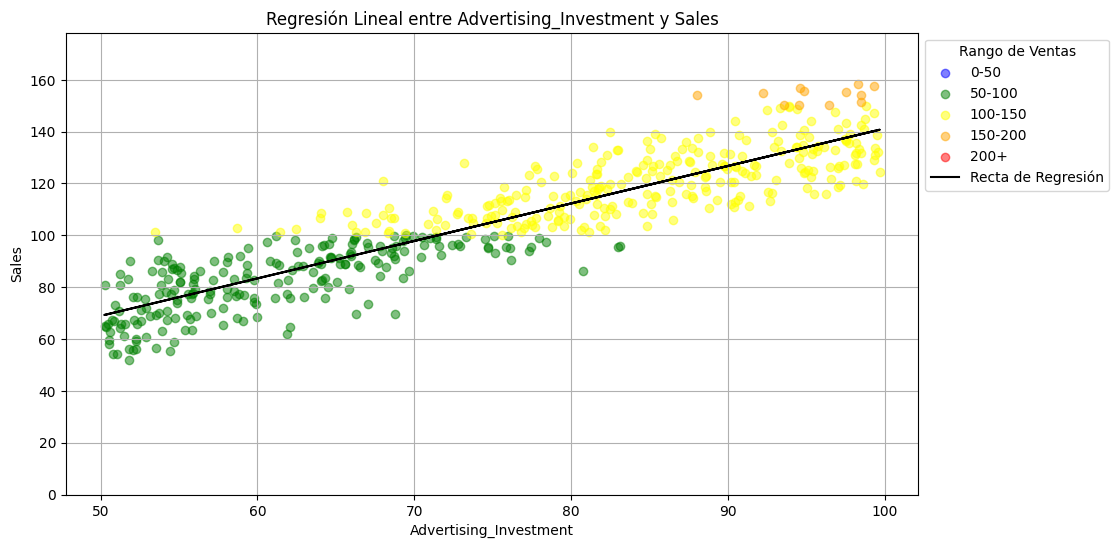

Intercepto: -3.370562694083759
Pendiente: 1.4460009245782883
Coeficiente de Determinación (R^2): 0.8220590554973619
Coeficiente de Correlación: 0.9066747241968105
Tabla ANOVA para la Regresión Lineal:
+----+-----------------------+---------------------+----------------------+-------------------------+-------------------+
|    | Fuente de Variación   |   Suma de Cuadrados |   Grados de Libertad | Promedio de Cuadrados   | Estadístico F     |
+====+=======================+=====================+======================+=========================+===================+
|  0 | Regresión             |            232710   |                    1 | 232709.67144348542      | 2300.681334371678 |
+----+-----------------------+---------------------+----------------------+-------------------------+-------------------+
|  1 | Residual              |             50371.8 |                  498 | 101.1481546648176       |                   |
+----+-----------------------+---------------------+---------------

In [12]:
#Aplicación de Regresión Lineal

# Cargar los datos
df = pd.read_csv("./data/cleandata/question3.csv")

# Definir las columnas
x_column = "Advertising_Investment"
y_column = "Sales"

# Definir los intervalos (bins) y colores
bins = [0, 50, 100, 150, 200, np.inf]
colors = ['blue', 'green', 'yellow', 'orange', 'red']
labels = ['0-50', '50-100', '100-150', '150-200', '200+']

def scatter_plot_with_regression(df, x_column, y_column, bins, colors, labels):
    # Asignar colores según el rango de ventas
    df['Color'] = pd.cut(df[y_column], bins=bins, labels=colors)

    # Gráfico de dispersión
    plt.figure(figsize=(11, 6))
    for color, label in zip(colors, labels):
        subset = df[df['Color'] == color]
        plt.scatter(subset[x_column], subset[y_column], alpha=0.5, label=label, color=color)

    # Ajustar el modelo de regresión lineal
    x = df[[x_column]]
    y = df[y_column]
    model = LinearRegression()
    model.fit(x, y)

    # Predicciones y cálculo de coeficientes
    df['Sales_Pred'] = model.predict(x)
    intercept = model.intercept_
    slope = model.coef_[0]
    r_squared = r2_score(y, df['Sales_Pred'])

    # Gráfico de la recta de regresión
    plt.plot(df[x_column], df['Sales_Pred'], color='black', label='Recta de Regresión')
    plt.title(f'Regresión Lineal entre {x_column} y {y_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.ylim(0, df[y_column].max() + 20)
    plt.legend(title='Rango de Ventas', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

    # Imprimir coeficientes y R^2
    print(f"Intercepto: {intercept}")
    print(f"Pendiente: {slope}")
    print(f"Coeficiente de Determinación (R^2): {r_squared}")

    # Calcular coeficiente de correlación
    correlation_coef = np.corrcoef(df[x_column], df[y_column])[0, 1]
    print(f"Coeficiente de Correlación: {correlation_coef}")

    return model, intercept, slope, r_squared

# Llamar a la función
model, intercept, slope, r_squared = scatter_plot_with_regression(df, x_column, y_column, bins, colors, labels)

def anova_table(model, df, x_column, y_column):
    # Número de observaciones y parámetros
    n = len(df)
    p = 1  # Solo un predictor

    # Suma de cuadrados total
    ss_total = np.sum((df[y_column] - np.mean(df[y_column]))**2)
    
    # Suma de cuadrados de regresión
    ss_regression = np.sum((df['Sales_Pred'] - np.mean(df[y_column]))**2)
    
    # Suma de cuadrados residual (errores)
    ss_residual = np.sum((df[y_column] - df['Sales_Pred'])**2)

    # Grados de libertad
    df_total = n - 1
    df_regression = p
    df_residual = n - p - 1

    # Promedio de cuadrados
    ms_regression = ss_regression / df_regression
    ms_residual = ss_residual / df_residual

    # Estadístico F
    f_value = ms_regression / ms_residual

    # Tabla ANOVA
    anova_table = {
        'Fuente de Variación': ['Regresión', 'Residual', 'Total'],
        'Suma de Cuadrados': [ss_regression, ss_residual, ss_total],
        'Grados de Libertad': [df_regression, df_residual, df_total],
        'Promedio de Cuadrados': [ms_regression, ms_residual, ''],
        'Estadístico F': [f_value, '', '']
    }

    # Convertir la tabla en un DataFrame para formatearla con tabulate
    anova_df = pd.DataFrame(anova_table)

    print("Tabla ANOVA para la Regresión Lineal:")
    print(tabulate(anova_df, headers='keys', tablefmt='grid'))

    # Explicación detallada
    explanation = """
    Tabla ANOVA (Análisis de Varianza) para la Regresión Lineal:
    ------------------------------------------------------------
    - Suma de Cuadrados (SS): Medida de la variabilidad total en los datos.
      - SS Total: Variabilidad total en las ventas.
      - SS Regresión: Variabilidad explicada por el modelo de regresión.
      - SS Residual: Variabilidad no explicada por el modelo (errores).
    
    - Grados de Libertad (DF): Cantidad de información utilizada para estimar una suma de cuadrados.
      - DF Total: Número de observaciones menos uno.
      - DF Regresión: Número de predictores (en este caso, 1).
      - DF Residual: Observaciones menos parámetros del modelo menos uno.
    
    - Promedio de Cuadrados (MS): Suma de cuadrados dividida por sus respectivos grados de libertad.
      - MS Regresión: Variabilidad media explicada por el modelo.
      - MS Residual: Variabilidad media no explicada por el modelo.
    
    - Estadístico F: Relación entre MS Regresión y MS Residual. Indica si el modelo de regresión es significativo.
    
    En este análisis, el coeficiente de determinación (R^2) indica la proporción de la variabilidad en las ventas 
    que se puede explicar por la inversión en publicidad. Un valor cercano a 1 sugiere una relación fuerte, mientras 
    que un valor cercano a 0 sugiere una relación débil.
    
    El coeficiente de correlación mide la fuerza y la dirección de la relación lineal entre dos variables. Un valor 
    positivo indica una relación directa, mientras que un valor negativo indica una relación inversa.
    """
    
    print(explanation)

# Llamar a la función ANOVA
anova_table(model, df, x_column, y_column)

In [13]:
#Intervalos de Confianza y Pruebas de Hipótesis

# Cargar los datos
df = pd.read_csv("./data/cleandata/question3.csv")
x_column = "Advertising_Investment"
y_column = "Sales"

def confidence_intervals_and_hypothesis_tests(df, x_column, y_column):
    # Preparar los datos para statsmodels
    X = sm.add_constant(df[x_column])  # Agregar una constante para el intercepto
    y = df[y_column]

    # Ajustar el modelo de regresión
    model = sm.OLS(y, X).fit()

    # Obtener los coeficientes y sus errores estándar
    intercept, slope = model.params
    intercept_se, slope_se = model.bse

    # Grados de libertad residuales
    df_residual = model.df_resid

    # Intervalos de confianza del 95%
    t_value = stats.t.ppf(1 - 0.025, df_residual)  # Valor crítico t para el 95% de confianza

    intercept_ci = (intercept - t_value * intercept_se, intercept + t_value * intercept_se)
    slope_ci = (slope - t_value * slope_se, slope + t_value * slope_se)

    print("Intervalos de Confianza del 95%:")
    print(f"Intercepto: {intercept_ci}")
    print(f"Pendiente: {slope_ci}")

    # Explicación de los Intervalos de Confianza
    print("\nInterpretación de los Intervalos de Confianza:")
    print(f"El intervalo de confianza del 95% para el intercepto es {intercept_ci},")
    print("lo que significa que estamos 95% seguros de que el verdadero valor del intercepto se encuentra dentro de este rango.")
    print(f"El intervalo de confianza del 95% para la pendiente es {slope_ci},")
    print("lo que significa que estamos 95% seguros de que el verdadero valor de la pendiente se encuentra dentro de este rango.")

    # Pruebas de Hipótesis
    print("\nPruebas de Hipótesis:")
    summary = model.summary2().tables[1]
    p_values = summary['P>|t|']
    
    for param, p_value in p_values.items():
        if p_value < 0.05:
            print(f"Coeficiente {param}: p-value = {p_value:.4f} -> Rechazamos H0 (significativo)")
        else:
            print(f"Coeficiente {param}: p-value = {p_value:.4f} -> No rechazamos H0 (no significativo)")

    # Explicación de las Pruebas de Hipótesis
    print("\nInterpretación de las Pruebas de Hipótesis:")
    print("Hipótesis nula (H0): El coeficiente es igual a cero (no hay efecto).")
    print("Hipótesis alternativa (H1): El coeficiente es diferente de cero (hay efecto).")
    print("Evaluación:")
    print("Si el valor p es menor a 0.05, rechazamos la hipótesis nula y concluimos que el coeficiente es significativo.")
    print("Si el valor p es mayor o igual a 0.05, no rechazamos la hipótesis nula y concluimos que el coeficiente no es significativo.")

    return model, intercept, slope, intercept_ci, slope_ci, summary

# Llamar a la función
model, intercept, slope, intercept_ci, slope_ci, summary = confidence_intervals_and_hypothesis_tests(df, x_column, y_column)

Intervalos de Confianza del 95%:
Intercepto: (-7.8957122151702, 1.1545868270026078)
Pendiente: (1.3867704519183977, 1.50523139723818)

Interpretación de los Intervalos de Confianza:
El intervalo de confianza del 95% para el intercepto es (-7.8957122151702, 1.1545868270026078),
lo que significa que estamos 95% seguros de que el verdadero valor del intercepto se encuentra dentro de este rango.
El intervalo de confianza del 95% para la pendiente es (1.3867704519183977, 1.50523139723818),
lo que significa que estamos 95% seguros de que el verdadero valor de la pendiente se encuentra dentro de este rango.

Pruebas de Hipótesis:
Coeficiente const: p-value = 0.1440 -> No rechazamos H0 (no significativo)
Coeficiente Advertising_Investment: p-value = 0.0000 -> Rechazamos H0 (significativo)

Interpretación de las Pruebas de Hipótesis:
Hipótesis nula (H0): El coeficiente es igual a cero (no hay efecto).
Hipótesis alternativa (H1): El coeficiente es diferente de cero (hay efecto).
Evaluación:
Si e

----